In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from multiprocessing import Pool
import healpy as hp
from astropy.coordinates import SkyCoord
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# %matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d    
import random
from sklearn.svm import SVC
from sklearn import svm

In [26]:
 # Importing the dataset containing optical clusters
df = pd.read_csv('ml_sample_real.csv', skiprows = 0, index_col=0)
# df.sort_values(by=['amf_rh'],ascending=False)
df.head()

,amf_z,amf_rh,glat,glon,amf_sn,intensity100,intensity857,intensity143,intensity353,cluster,intensity217,intensity545,intensity090_act,intensity150_act,intensity220_act
0,0.2252,200.7117,31.846666,55.602221,24.655148,-0.000048,1.978746,-0.000006,0.001062,1,0.000159,0.827244,0.0,0.0,0.0
1,0.2248,182.3373,41.429880,72.599428,44.674799,-0.000269,1.196847,-0.000215,0.000722,1,-0.000032,0.575222,0.0,0.0,0.0
2,0.3110,179.1883,65.305106,107.103759,25.696075,-0.000124,1.019871,-0.000129,0.000580,1,-0.000016,0.509922,0.0,0.0,0.0
3,0.5231,174.7108,-29.646780,100.211077,13.793623,0.000047,4.913466,0.000091,0.001929,1,0.000302,1.806498,0.0,0.0,0.0
4,0.2574,172.6889,43.387615,166.090009,20.839521,0.000029,1.074994,0.000060,0.000894,1,0.000183,0.555347,0.0,0.0,0.0


In [53]:
# Convert the RA and DEC to galactic coordinates
fakeras = np.loadtxt('fakeras.csv',delimiter=', ')
fakedecs = np.loadtxt('fakedecs.csv',delimiter=', ')

c = SkyCoord(fakeras,fakedecs,frame='icrs',unit='deg')
df2['glat'] = c.galactic.b.degree
df2['glon'] = c.galactic.l.degree

In [205]:
fake_ras = []
fake_decs = []

ras = np.linspace(0,360,150)
decs = np.linspace(-90,90,150)

In [206]:
for ra in ras:
    for dec in decs:
        fake_ras.append(ra)
        fake_decs.append(dec)

In [207]:
c = SkyCoord(fake_ras,fake_decs,frame='icrs',unit='deg')
lats = c.galactic.b.degree
lons = c.galactic.l.degree

In [208]:
# plt.hist(df['intensity100'],bins=100,alpha=0.5,density=True)
# plt.hist(df2['intensity100'],bins=100,alpha=0.5,density=True)

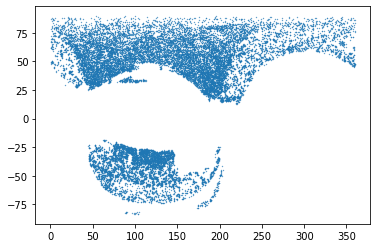

In [220]:
# plt.scatter(lons,lats,s=0.5)
plt.scatter(df['glon'],df['glat'],s=0.1)

In [210]:
temp = pd.DataFrame({'ras':fake_ras,
                     'decs':fake_decs,
                     'lats':lats,
                     'lons':lons
})

In [216]:
temp2 = temp[(temp['lats']>25)|(temp['lats']<-25)]

In [217]:
temp2

,ras,decs,lats,lons
0,0.0,-90.000000,-27.128252,302.931925
1,0.0,-88.791946,-28.305676,303.237283
2,0.0,-87.583893,-29.482404,303.549475
3,0.0,-86.375839,-30.658387,303.869001
4,0.0,-85.167785,-31.833569,304.196396
...,...,...,...,...
22452,360.0,33.221477,-28.426497,110.709256
22453,360.0,34.429530,-27.249142,111.015294
22454,360.0,35.637584,-26.071137,111.314919
22498,360.0,88.791946,25.950183,122.632933


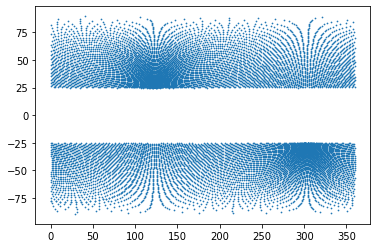

In [219]:
plt.scatter(temp2['lons'],temp2['lats'],s=0.5)

In [6]:
# Importing the dataset containing non-clusters
df2 = pd.read_csv('ml_sample_fake.csv', skiprows = 0, index_col=0)
df2.head()

,amf_z,amf_rh,glat,glon,amf_sn,intensity100,intensity857,intensity143,intensity353,cluster,intensity217,intensity545
0,0,0,33.564390,55.334276,0,0.000002,2.059887,0.000026,0.000905,0,1.188474e-04,0.830211
1,0,0,42.040259,68.867812,0,0.000024,0.898348,0.000040,0.000564,0,8.879348e-05,0.427894
2,0,0,67.923338,104.122599,0,-0.000029,1.226182,-0.000059,0.000553,0,-3.727869e-07,0.554440
3,0,0,-26.767368,100.662793,0,0.000083,2.584038,0.000092,0.001094,0,1.912677e-04,0.996217
4,0,0,44.967772,165.363763,0,-0.000046,1.149241,0.000006,0.000507,0,4.130510e-05,0.563971


In [7]:
# Combine real and fake data
df3 = df.append(df2, ignore_index=True)

In [25]:
# df2['intensity090_act'] = np.loadtxt('actintensity090.csv',delimiter=', ')
# df2['intensity150_act'] = np.loadtxt('actintensity150.csv',delimiter=', ')
# df2['intensity220_act'] = np.loadtxt('actintensity220.csv',delimiter=', ')
# df.to_csv("ml_sample_real.csv")

---

# Predicting signal in one frequency based on signal in others

#### Training

In [8]:
# From the signal in the 100Ghz image and 353Ghz image, determine the expected signal in 143Ghz
# 50 percent of the sample has richness over 27, use the richer sample for training
X = df[['intensity100', 'intensity353']][::2]
y = df['intensity143'][::2]
regr = linear_model.LinearRegression()
regr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### Validation

In [9]:
# Build array of predictions for the half of the sample not used in training
X_val = df[['intensity100', 'intensity353']][1::2]

intensity143 = [regr.predict([[i,j]]) for i, j in X_val.values]

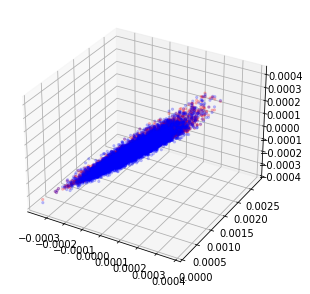

In [10]:
# Plot actual data vs predictions in three dimensions
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(projection='3d')

ax.scatter(df['intensity100'][1::2], df['intensity353'][1::2], df['intensity143'][1::2],s=5,c='b', alpha=0.2)
ax.scatter(df['intensity100'][1::2], df['intensity353'][1::2], intensity143, s=5, c='r', alpha=0.2)
plt.show()

---

# Classification of clusters vs non clusters

In [37]:
# From the signal in the 100Ghz image and 353Ghz image, determine the expected signal in 143Ghz
# 50 percent of the sample has richness over 27, use the richer sample for training
X = df[['intensity100', 'intensity143', 'intensity353']]
X_f = df2[['intensity100', 'intensity143', 'intensity353']]
X2 = df3[['intensity100', 'intensity143', 'intensity353']]
y2 = df3['cluster']
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
#clf = svm.SVR()
clf.fit(X2, y2)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='auto', kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [38]:
cluster = np.array([clf.predict([[i,j,k]]) for i, j, k in X.values]).flatten()

In [39]:
no_cluster = np.array([clf.predict([[i,j,k]]) for i, j, k in X_f.values]).flatten()

(array([41.49766733,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

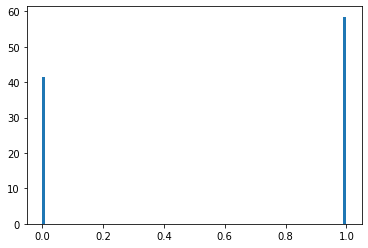

In [40]:
plt.hist(cluster,bins=100,range=(0,1),density=True)
#plt.vlines(0.5,0,2000,color='r',linestyles='dotted')
#plt.ylim(0,4)

(array([44.92049891,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

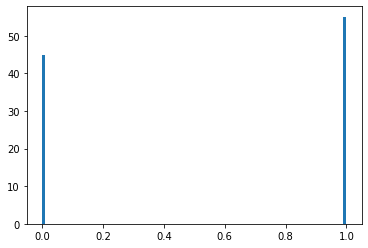

In [41]:
plt.hist(no_cluster,bins=100,range=(0,1),density=True)
#plt.vlines(0.5,0,2000,color='r',linestyles='dotted')
#plt.ylim(0,9)

---

# Identification of clusters

In [42]:
# Csv importer wrapped in a function that can be mapped for parallelization
def read_csv(filename):
    return pd.DataFrame(np.loadtxt(filename,delimiter=', ')).T

In [43]:
links100 = ['../data/results100_1.csv','../data/results100_2.csv','../data/results100_3.csv',
         '../data/results100_4.csv','../data/results100_5.csv','../data/results100_6.csv',
         '../data/results100_7.csv','../data/results100_8.csv','../data/results100_9.csv',
         '../data/results100_10.csv']
links143 = ['../data/results143_1.csv','../data/results143_2.csv','../data/results143_3.csv',
         '../data/results143_4.csv','../data/results143_5.csv','../data/results143_6.csv',
         '../data/results143_7.csv','../data/results143_8.csv','../data/results143_9.csv',
         '../data/results143_10.csv']
links353 = ['../data/results353_1.csv','../data/results353_2.csv','../data/results353_3.csv',
         '../data/results353_4.csv','../data/results353_5.csv','../data/results353_6.csv',
         '../data/results353_7.csv','../data/results353_8.csv','../data/results353_9.csv',
         '../data/results353_10.csv']

In [44]:
for links in [links100,links143,links353]:
    with Pool() as pool: 
        df_list = pool.map(read_csv, links)
        if links==links100:
            data100 = pd.concat(df_list, ignore_index=True)
        if links==links143:
            data143 = pd.concat(df_list, ignore_index=True)
        if links==links353:
            data353 = pd.concat(df_list, ignore_index=True)

In [45]:
data100 = pd.DataFrame()
data143 = pd.DataFrame()
data353 = pd.DataFrame()

for links in [links100,links143,links353]:
    if links==links100:
        for link in links:
            data100 = pd.concat([data100,pd.DataFrame(np.loadtxt(link,delimiter=', ')).T])
    if links==links143:
        for link in links:
            data143 = pd.concat([data143,pd.DataFrame(np.loadtxt(link,delimiter=', ')).T])
    if links==links353:
        for link in links:
            data353 = pd.concat([data353,pd.DataFrame(np.loadtxt(link,delimiter=', ')).T])

In [46]:
data100

,0,1,2
0,-0.000073,0.000000,-90.0
1,-0.000074,3.636364,-90.0
2,-0.000074,7.272727,-90.0
3,-0.000075,10.909091,-90.0
4,-0.000076,14.545455,-90.0
...,...,...,...
9995,0.000031,345.454545,90.0
9996,0.000032,349.090909,90.0
9997,0.000032,352.727273,90.0
9998,0.000031,356.363636,90.0


In [47]:
pl143 = hp.read_map('../data/HFI_SkyMap_143-field-IQU_2048_R3.00_full.fits')

/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/maamari/Documents/Other/Anaconda/lib/python3.7/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [48]:
# Convert the RA and DEC to galactic coordinates
c = SkyCoord(data100[1],data100[2],frame='icrs',unit='deg')
data100['glat'] = c.galactic.b.degree
data100['glon'] = c.galactic.l.degree

c = SkyCoord(data143[1],data143[2],frame='icrs',unit='deg')
data143['glat'] = c.galactic.b.degree
data143['glon'] = c.galactic.l.degree

c = SkyCoord(data353[1],data353[2],frame='icrs',unit='deg')
data353['glat'] = c.galactic.b.degree
data353['glon'] = c.galactic.l.degree

In [49]:
# initialize data of lists.
data_all = {'int100':data100[0],
            'int143':data143[0],
            'int353':data353[0]}
 
intensity_all = pd.DataFrame(data_all)

In [50]:
cluster_prob = np.array([clf.predict([[i,j,k]]) for i, j, k in intensity_all[['int100', 'int143', 'int353']].values]).flatten()

In [51]:
data100['cluster']=cluster_prob

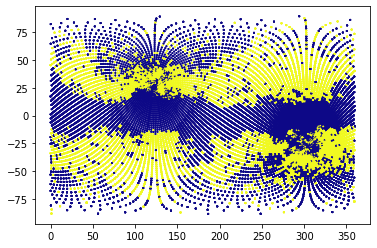

In [52]:
# hp.mollview(pl143,norm='hist',cmap='Greys',coord=['G'],title='Masked S/N map')
# hp.visufunc.projscatter(data100['glon'],data100['glat'],c=data100.cluster,cmap='plasma',lonlat=True,s=10)
plt.scatter(data100['glon'],data100['glat'],c=data100.cluster,cmap='plasma',s=1)
# plt.scatter(df['glon'],df['glat'],c='r')